# MAF vs. NSF: number of parameters and convergence time

We have seen (cf. `toy_examples_nflows.ipynb`) that NSF is more flexible and expressive than MAF for complex data distributions (e.g. spirals), or when fewer training samples are used (e.g. checkerboard). Other observations were that NSF takes longer to train , but convergence is faster. 

However, for certain tasks (e.g. blobs or moons), a MAF with enough hidden features can be a better fit, as the result is more smooth and training takes less time. 

The main takeaway was that NSF is to be used when the target data distribution is non-gaussian, as MAF fails. 

We here propose a clean comparison of those two flow architectures that should answer the following questions: 
- how many parameters do they have?
- how long does training take?
- how fast is convergence? 

We do this analysis for normal and conditional density estimation on simple toy examples (moons, conditional moons). We do this asking ourselves if it would be useful to find an architecture that is as flexible as NSFs (capable of estimating complex data distributions), but as fast (for training) as MAF. 

In [1]:
import numpy as np
import torch

import sys
sys.path.append('../data/')
from toy_data import inf_train_gen

sys.path.append('../flows/')
from nf_flows import construct_maf, construct_nsf
from train import train

## Density estimation: Moons dataset

In [2]:
# Data Dimensions
n = 5000 # Number of datapoints

# Training samples 
x_samples = inf_train_gen(data='moons', batch_size=n)
x_samples = torch.FloatTensor(x_samples)

# Flow
maf = construct_maf(x_samples, hidden_features=50)
nsf = construct_nsf(x_samples, hidden_features=50, num_bins = 10)

In [3]:
# Count parameters 
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(maf), count_parameters(nsf)

(52770, 58925)

In [4]:
# Tune NSF hyper-parameters (hidden_features, num_bins) to match the number of parameters of MAF
min_diff = 1000
for bins in range(3,11): # not less than 3, otherwise it's for sure not more expressive than MAF 
    for hf in range(40,51):
        nsf = construct_nsf(x_samples, hidden_features=hf, num_bins = bins)
        nb_params =  count_parameters(nsf)
        diff = np.abs(nb_params - count_parameters(maf))
        if  diff < min_diff:
            min_diff = diff
            best_params = nb_params
            best_bins = bins
            best_hf = hf
print(f'num_bins = {best_bins}, hidden_features = {best_hf}: {best_params}')

# construct new NSF 
nsf = construct_nsf(x_samples, hidden_features=best_hf, num_bins = best_bins)

num_bins = 10, hidden_features = 47: 52580


/Users/julialinhart/Documents/Code/github/NormalizingFlows/notebooks/../flows/eval.py:51: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  xline = torch.linspace(plt_min, plt_max)
/opt/miniconda3/envs/nflows/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


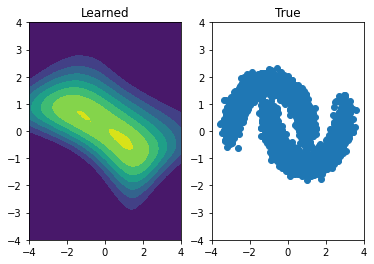

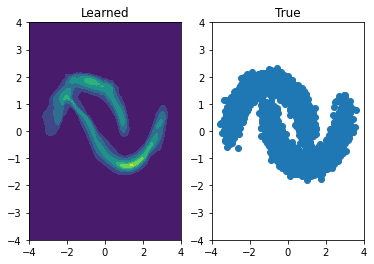

In [5]:
# Train maf
best_val_loss_maf, epochs_maf = train(maf, x_samples, num_epochs=2000, batch_size=n//10, lr=0.005, plt_min=-4., plt_max=4., validation=True)

In [6]:
best_val_loss_maf, epochs_maf

(0.005103579521179199, 58)

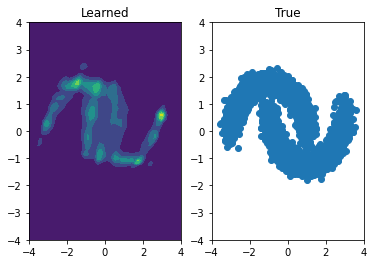

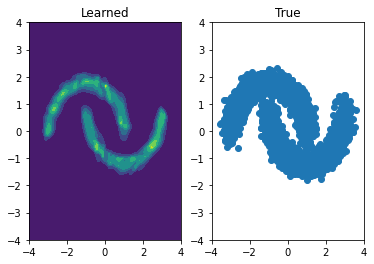

In [7]:
# Train nsf 
best_val_loss_nsf, epochs_nsf = train(nsf, x_samples, num_epochs=2000, batch_size=n//10, lr=0.005, plt_min=-4., plt_max=4., validation=True)

In [8]:
best_val_loss_nsf, epochs_nsf

(0.004983170986175537, 46)